# Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torchvision
import torchaudio
import lightgbm as lgb
import xgboost as xgb
import imblearn
import scipy
import statsmodels.api as sm
import openpyxl
import shap
import plotly
import lifelines
import optuna

# Configs

In [34]:
# Atlassian Brand Colours
atlassian_colors = [
    "#0052CC",  # Atlassian Blue (primary)
    "#2684FF",  # Bright Blue
    "#57D9A3",  # Green accent
    "#FFAB00",  # Gold accent
    "#FF5630",  # Red accent
    "#36B37E",  # Secondary green
    "#6554C0"   # Purple accent
]

# Set Global Theme
sns.set_theme(
    style="whitegrid",
    palette=atlassian_colors,
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.edgecolor": "#DFE1E6",  # Atlassian light gray
        "axes.linewidth": 1.0,
        "axes.facecolor": "white",
        "figure.facecolor": "white"
    }
)

# Import datasets

In [35]:
billing_df = pd.read_csv("../datasets/billing.csv")
events_df = pd.read_csv("../datasets/events.csv")
sessions_df = pd.read_csv("../datasets/sessions.csv")
users_df = pd.read_csv("../datasets/users.csv")

# User Dataset EDA

In [36]:
users_df

,user_id,signup_date,plan_tier,company_size,region,industry,acquisition_channel,is_enterprise,churned_30d,churned_90d,downgraded,expansion_event
0,f94d1824-8742-4000-8b6d-39d70958490b,2024-05-13,free,11-50,EU,software,seo,False,0,0,0,1
1,238bf0af-1f71-45e4-a47d-dcb5db33f71b,2025-04-11,standard,1-10,NaN,education,seo,False,0,0,0,0
2,ccf8fc06-3c86-433c-8867-9cba0fda337b,2024-10-28,free,1-10,APAC,transport,partner,False,0,0,0,1
3,3e39c0ea-ebbf-43bc-abd5-ab92eff6fa10,2024-05-17,standard,200+,APAC,software,partner,False,0,0,0,1
4,9304dcbe-682d-41fa-8bfd-861559f9f58b,2024-04-12,free,1-10,NaN,software,ads,False,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,e7e9d70c-478e-4d57-982a-53c98a175328,2024-09-17,premium,51-200,NaN,retail,partner,True,0,0,0,0
99996,1b74fc26-9c01-4aeb-95db-587abfda6e73,2024-04-29,free,11-50,NaN,finance,partner,False,0,1,0,1
99997,c209e590-7bcc-4aff-b3cd-c9c498491c22,2024-11-24,free,1-10,NaN,transport,seo,False,0,0,0,1
99998,06bde50d-e9b3-4db9-8353-cf0279d0060b,2025-05-01,premium,11-50,APAC,manufacturing,seo,False,0,0,0,0


In [37]:
users_df.shape

(100000, 12)

In [38]:
users_df.columns

Index(['user_id', 'signup_date', 'plan_tier', 'company_size', 'region',
       'industry', 'acquisition_channel', 'is_enterprise', 'churned_30d',
       'churned_90d', 'downgraded', 'expansion_event'],
      dtype='object')

## Users over time

In [39]:
# Find range of signup dates
print(users_df['signup_date'].agg(["min","max"]))

min    2024-02-01
max    2025-06-30
Name: signup_date, dtype: object


In [40]:
users_df["user_id"].nunique()

100000

In [41]:
users_df["signup_date"].nunique()

516

In [42]:
users_df["signup_date"] = pd.to_datetime(users_df["signup_date"])

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/3669620185.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")   # "W" for weekly, "M" for monthly


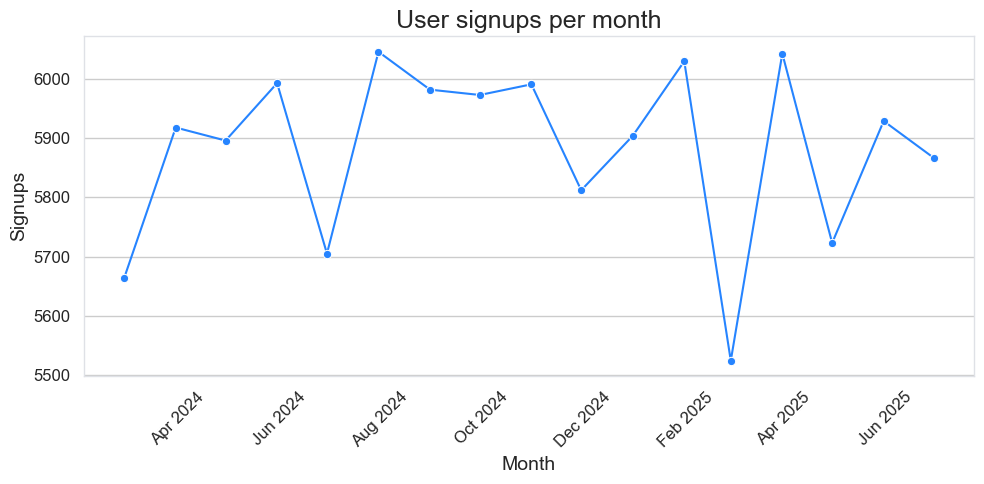

In [43]:
import matplotlib.dates as mdates

# aggregate by month
monthly = (
    users_df.set_index("signup_date")
            .resample("M")   # "W" for weekly, "M" for monthly
            .size()
            .rename("signups")
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=monthly.index, y=monthly.values, ax=ax, marker="o", color="#2684FF")

ax.set_title("User signups per month")
ax.set_xlabel("Month")
ax.set_ylabel("Signups")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.grid(False) 
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


Large variance in user signups

## Users by region

In [44]:
# Count total signups by region
region_counts = users_df["region"].value_counts().reset_index()
region_counts.columns = ["region", "signups"]
print(region_counts)

  region  signups
0   APAC    27810
1     EU    25960
2  LATAM     8006


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/3094377692.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="region", y="signups", data=region_counts, ax=ax, palette="Blues")


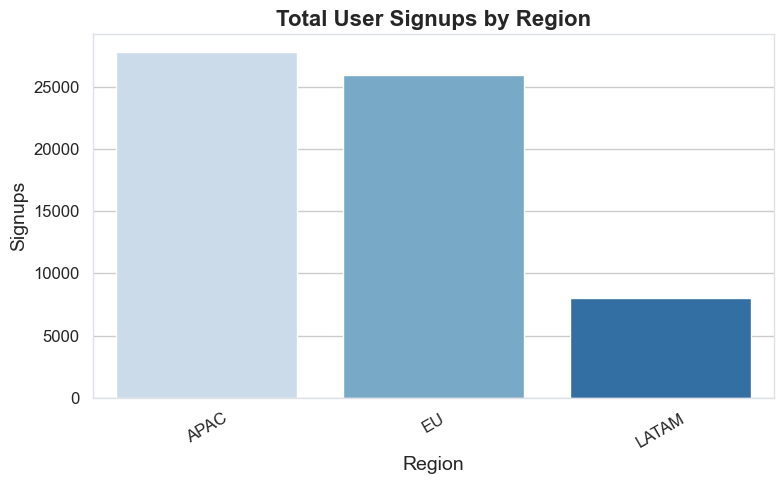

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x="region", y="signups", data=region_counts, ax=ax, palette="Blues")

ax.set_title("Total User Signups by Region", fontsize=16, weight="bold")
ax.set_xlabel("Region")
ax.set_ylabel("Signups")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [46]:
industry_counts = users_df['industry'].value_counts().reset_index()
industry_counts.columns = ["industry", "signups"]
print(industry_counts)


        industry  signups
0      education    10129
1  manufacturing    10126
2     healthcare    10107
3       software    10029
4        finance    10012
5      transport    10010
6          media     9959
7         energy     9941
8        telecom     9852
9         retail     9835


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/845446022.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="industry", y="signups", data=industry_counts, ax=ax, palette="Blues")


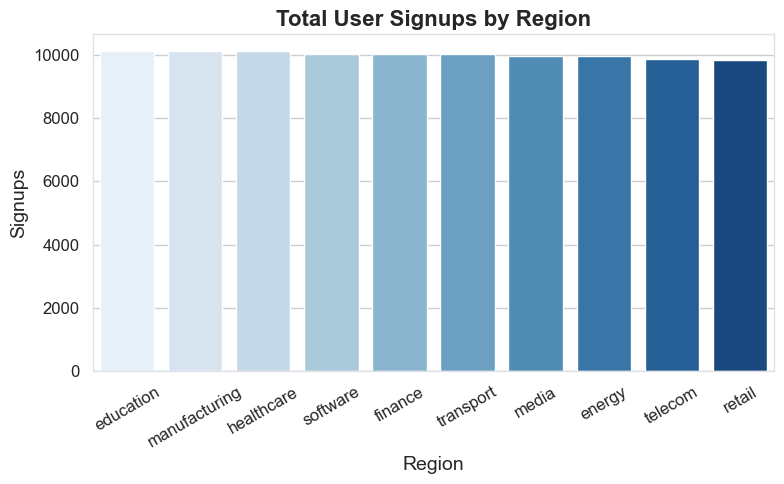

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x="industry", y="signups", data=industry_counts, ax=ax, palette="Blues")

ax.set_title("Total User Signups by Region", fontsize=16, weight="bold")
ax.set_xlabel("Region")
ax.set_ylabel("Signups")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Seems like all industries have relatively similar usage.  

## Channel

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/659570305.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_counts, x="channel", y="signups", ax=ax, palette="Blues_d")


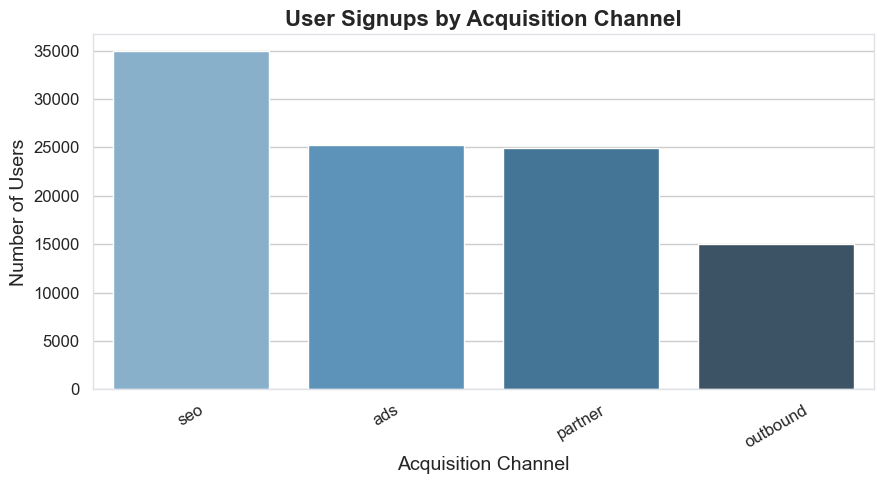

In [48]:
channel_counts = (
    users_df["acquisition_channel"]
    .value_counts()
    .reset_index()
)
channel_counts.columns = ["channel", "signups"]

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=channel_counts, x="channel", y="signups", ax=ax, palette="Blues_d")

ax.set_title("User Signups by Acquisition Channel", fontsize=16, weight="bold")
ax.set_xlabel("Acquisition Channel")
ax.set_ylabel("Number of Users")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Enterprise

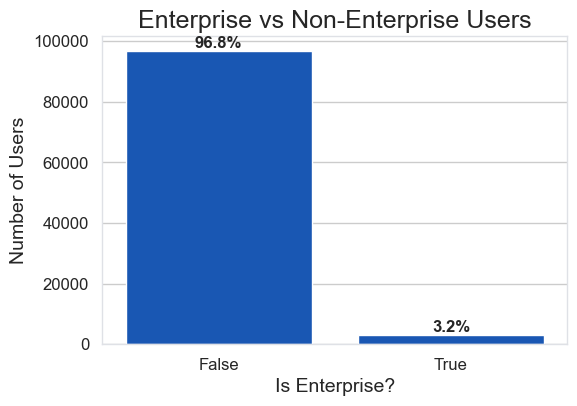

In [49]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="is_enterprise", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("Enterprise vs Non-Enterprise Users")
ax.set_xlabel("Is Enterprise?")
ax.set_ylabel("Number of Users")
plt.show()

## User tier

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/1851484709.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plan_tier_counts, x="plan_tier", y="signups", ax=ax, palette="Blues_d")


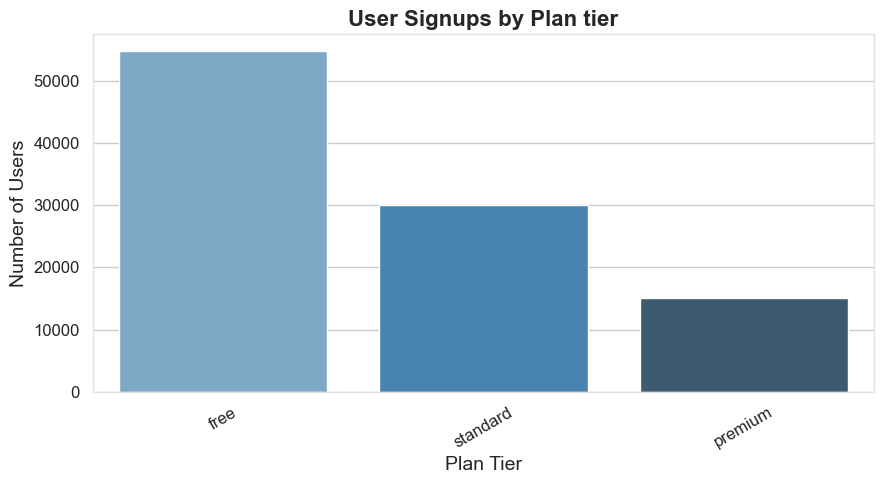

In [50]:
plan_tier_counts = (
    users_df["plan_tier"]
    .value_counts()
    .reset_index()
)
plan_tier_counts.columns = ["plan_tier", "signups"]

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=plan_tier_counts, x="plan_tier", y="signups", ax=ax, palette="Blues_d")

ax.set_title("User Signups by Plan tier", fontsize=16, weight="bold")
ax.set_xlabel("Plan Tier")
ax.set_ylabel("Number of Users")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

most people are on free tier, mabye understand what makes them upgrade or downgrade

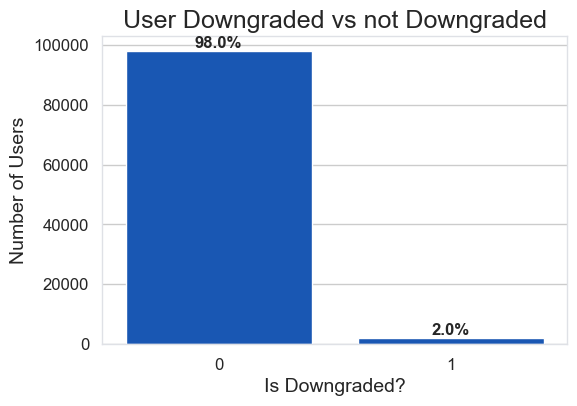

In [51]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="downgraded", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("User Downgraded vs not Downgraded")
ax.set_xlabel("Is Downgraded?")
ax.set_ylabel("Number of Users")
plt.show()

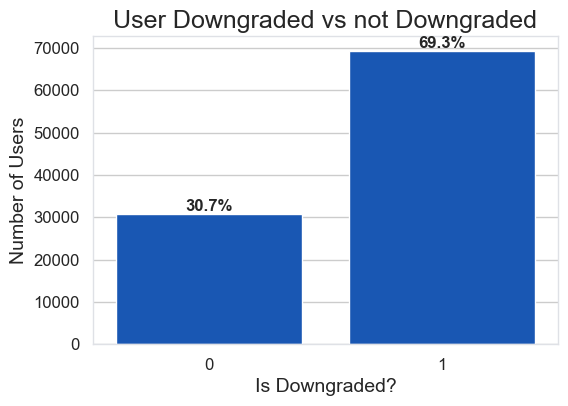

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="expansion_event", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("User Downgraded vs not Downgraded")
ax.set_xlabel("Is Downgraded?")
ax.set_ylabel("Number of Users")
plt.show()

# Session Dataset EDA

# Events Dataset EDA

In [53]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234329 entries, 0 to 234328
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   event_id      234329 non-null  object
 1   user_id       234329 non-null  object
 2   session_id    234329 non-null  object
 3   ts            234329 non-null  object
 4   feature_name  234329 non-null  object
 5   action        234329 non-null  object
 6   duration_ms   234329 non-null  int64 
 7   latency_ms    234329 non-null  int64 
 8   success       234329 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 16.1+ MB


In [54]:
events_df.isnull().sum()

event_id        0
user_id         0
session_id      0
ts              0
feature_name    0
action          0
duration_ms     0
latency_ms      0
success         0
dtype: int64

In [55]:
events_df.duplicated().sum()

np.int64(0)

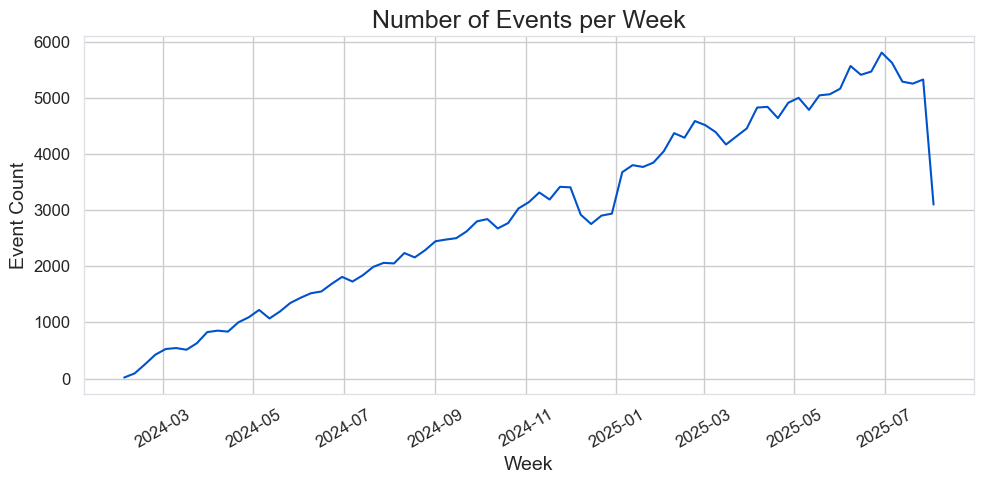

In [56]:
events_df["ts"] = pd.to_datetime(events_df["ts"])

# Per week counts
weekly_counts = (
    events_df.set_index("ts")
    .resample("W")
    .size()
    .reset_index(name="count")
)


fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=weekly_counts, x="ts", y="count", ax=ax)

ax.set_title("Number of Events per Week")
ax.set_xlabel("Week")
ax.set_ylabel("Event Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
Event activity has been steadily increasing, drop at the end from incomplete data.

### How active are the users?

In [58]:
events_df["event_id"]

0         665ea739-d80e-4d68-b0be-67b74b79984a
1         4259f36b-a4ec-41b2-9241-c2b90bf23f8c
2         c819fc5b-2d79-455a-9685-5347dae03f68
3         c0ea5e8e-7236-4cd6-ab25-6c97b7f22465
4         96819e5e-edf0-4277-87c1-5c16235c9dff
                          ...                 
234324    4493c55b-9e2d-4f81-a5b4-6b34b4539d83
234325    3df6c03f-3de8-4e6f-a392-3bee9bf72fdb
234326    21ad6200-ffe7-46dd-8e67-75e57820c0d9
234327    07c78acd-ffd1-434a-97fd-a759f37eafac
234328    f1e90b20-a7f7-4950-a4bb-4c3e3f4d66a7
Name: event_id, Length: 234329, dtype: object

In [ ]:
#Events per user summary stats
events_per_user_df = events_df.groupby("user_id")["event_id"].count()
events_per_user_df.describe()

count    57312.000000
mean         4.088655
std          3.644663
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         34.000000
Name: event_id, dtype: float64

This summary shows that the average user in the dataset generates about 4 events, but the distribution is highly skewed, half of users have 3 or fewer events, and 25% have only 1 event, suggesting a large proportion of users show very limited engagement after signing up. On the other end, some users are much more active, with up to 34 events, indicating a small segment of power users. Mabye users who have less events are more likely to churn?

### What type of users is the most active?

In [ ]:
# Merge user and events using outer join, as some users have not had an event
users_events_merged = pd.merge(events_df, users_df, on="user_id", how="outer")
users_events_merged

,event_id,user_id,session_id,ts,feature_name,action,duration_ms,latency_ms,success,signup_date,plan_tier,company_size,region,industry,acquisition_channel,is_enterprise,churned_30d,churned_90d,downgraded,expansion_event
0,9b73cdb9-3830-477f-a51e-a7b5ae243afc,0000093e-7258-43c0-b212-ea7212795ddf,a6c4d437-0689-4875-9e56-67b7725d1b43,2025-04-04 22:02:43.193165869,jira_board,view,793.0,97.0,1.0,2024-10-02,free,1-10,APAC,education,partner,False,0,1,0,1
1,NaN,0003c565-9352-45aa-a448-82b91e57b043,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2025-03-10,free,1-10,NaN,healthcare,ads,False,1,0,0,1
2,NaN,00044174-f9c1-4412-b9ca-584a21903f92,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2024-07-02,free,11-50,EU,energy,outbound,False,0,0,0,1
3,NaN,0005523a-ffde-4fe8-96d8-c203b1fe2f97,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2024-11-20,free,1-10,EU,healthcare,ads,False,0,0,0,1
4,e0e609f6-bfcd-4943-ab2e-8185eb366806,0006fdbd-c35d-4c0d-a948-e8ee10f279d5,3b46e30b-12bf-41e2-bd14-d2bc13ef1bb3,2025-02-12 23:54:17.167197759,confluence_ai_assist,complete,1516.0,108.0,1.0,2025-02-01,free,11-50,APAC,software,seo,False,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277012,aa370362-83a6-4825-b035-0ad830fd656d,fffe77cc-44fd-401f-8fdd-9fa06afc6bc8,8dc1e26f-235b-4fed-8b85-6b729b6f0dc8,2025-03-18 14:01:11.686676783,team_invite,complete,1741.0,119.0,1.0,2024-05-22,standard,51-200,EU,energy,outbound,False,0,0,0,0
277013,ad8d5219-70fc-4d79-9f1b-414d4ebb9068,fffe77cc-44fd-401f-8fdd-9fa06afc6bc8,8dc1e26f-235b-4fed-8b85-6b729b6f0dc8,2025-03-18 13:59:28.221739535,confluence_page,click,587.0,597.0,1.0,2024-05-22,standard,51-200,EU,energy,outbound,False,0,0,0,0
277014,2c85f727-3d17-4067-b1d4-a884748bc2df,fffea094-3414-40c4-bab2-3925ba64491d,aa1c24f2-7e21-4186-8da3-ee717d1386f1,2025-05-01 09:00:39.404062991,jira_board,view,1237.0,240.0,1.0,2025-03-07,premium,1-10,APAC,manufacturing,seo,False,1,0,0,1
277015,892943f4-533e-4369-8cf8-abf04bb2ed18,fffea094-3414-40c4-bab2-3925ba64491d,5235370f-6c62-4b45-b55a-f8355c008707,2025-05-31 15:15:55.123447380,team_invite,click,925.0,472.0,1.0,2025-03-07,premium,1-10,APAC,manufacturing,seo,False,1,0,0,1


In [86]:
events_by_industry = (
    users_events_merged
    .groupby("industry")
    .agg({"event_id": "count"})
    .rename(columns={"event_id": "event_count"})
)

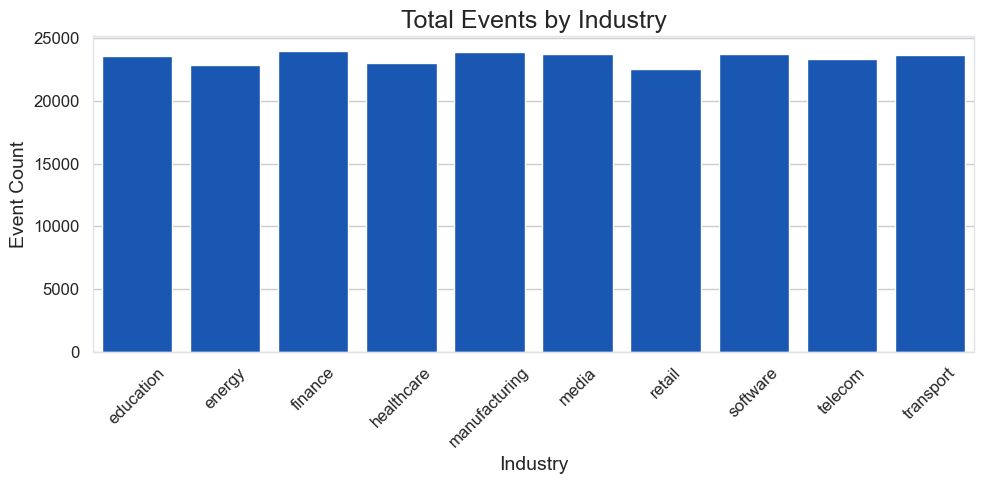

In [91]:
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=events_by_industry.reset_index(), x="industry", y="event_count", ax=ax)
ax.set_title("Total Events by Industry")
ax.set_xlabel("Industry")
ax.set_ylabel("Event Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
events_by_enterprise = (
    users_events_merged
    .groupby("is_enterprise")
    .agg(event_count=("event_id", "count"))
    .reset_index()
)
print(events_by_enterprise)

   is_enterprise  event_count
0          False       211165
1           True        23164


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/3035279024.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


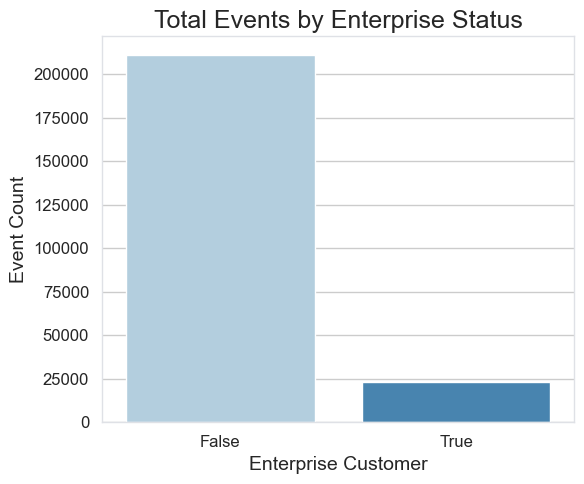

In [93]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(
    data=events_by_enterprise,
    x="is_enterprise",
    y="event_count",
    ax=ax,
    palette="Blues"
)

ax.set_title("Total Events by Enterprise Status")
ax.set_xlabel("Enterprise Customer")
ax.set_ylabel("Event Count")
plt.tight_layout()
plt.show()

In [94]:
events_per_user_enterprise = (
    users_events_merged
    .groupby("is_enterprise")
    .agg(
        total_events=("event_id", "count"),
        unique_users=("user_id", "nunique")
    )
    .assign(events_per_user=lambda d: d["total_events"] / d["unique_users"])
    .reset_index()
)

print(events_per_user_enterprise)

   is_enterprise  total_events  unique_users  events_per_user
0          False        211165         96794         2.181592
1           True         23164          3206         7.225203


In [98]:
events_per_user_industry = (
    users_events_merged
    .groupby("industry")
    .agg(
        total_events=("event_id", "count"),
        unique_users=("user_id", "nunique")
    )
    .assign(events_per_user=lambda d: d["total_events"] / d["unique_users"])
    .reset_index()
)

print(events_per_user_industry.head())

        industry  total_events  unique_users  events_per_user
0      education         23593         10129         2.329253
1         energy         22909          9941         2.304497
2        finance         23958         10012         2.392928
3     healthcare         23024         10107         2.278025
4  manufacturing         23914         10126         2.361643


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/2109469291.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


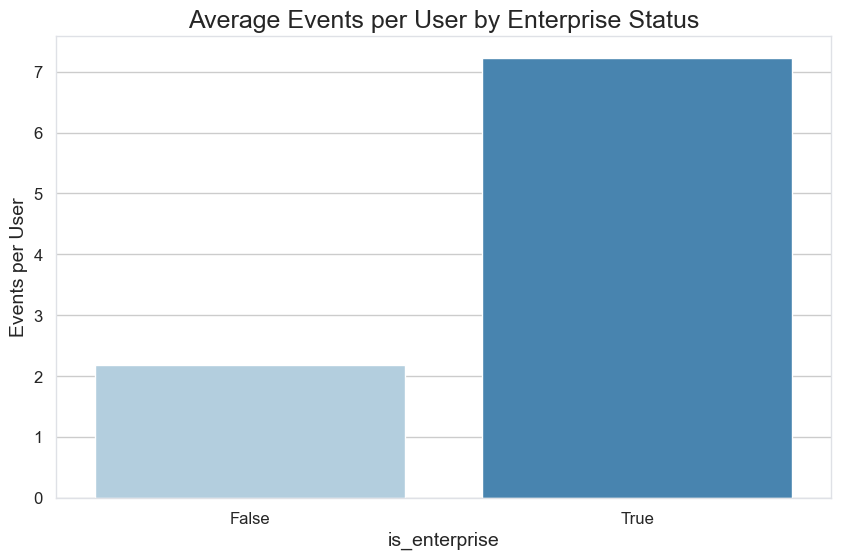

In [97]:
sns.barplot(
    data=events_per_user_enterprise,
    x="is_enterprise",
    y="events_per_user",
    palette="Blues"
)
plt.title("Average Events per User by Enterprise Status")
plt.ylabel("Events per User")
plt.show()

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_12064/3785531139.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


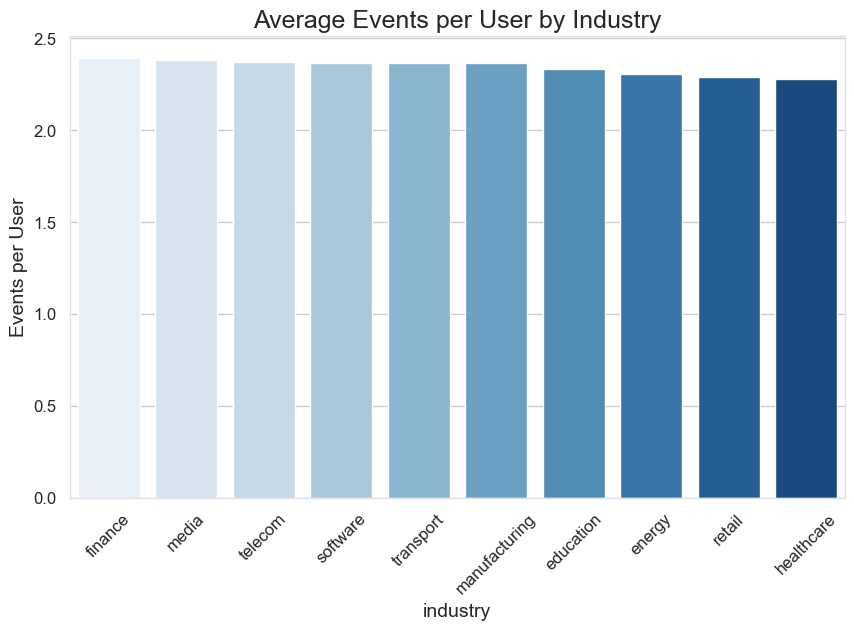

In [96]:
sns.barplot(
    data=events_per_user_industry.sort_values("events_per_user", ascending=False),
    x="industry",
    y="events_per_user",
    palette="Blues"
)
plt.title("Average Events per User by Industry")
plt.xticks(rotation=45)
plt.ylabel("Events per User")
plt.show()